# Cluster-FCI vs FCITiers on tiered background knowledge

This notebook shows how to simulate a MAG using the clustercausal.clustercausal.Simulator class, getting a C-DAG and/or tiered background knowledge compatible with the MAG and then running the Cluster-FCI and FCITiers algorithms on the generated data. The results are then compared. 

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")

import logging
logging.getLogger('rpy2').setLevel(logging.WARNING)

%load_ext autoreload
%autoreload 2
# from ipython import autoreload
import numpy as np
import itertools
import yaml
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import causallearn
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
from causallearn.search.ConstraintBased.FCI import fci
import random

from clustercausal.algorithms.ClusterPC import ClusterPC
from clustercausal.algorithms.ClusterFCI import ClusterFCI
from clustercausal.clusterdag.ClusterDAG import ClusterDAG
from clustercausal.experiments.Evaluator import Evaluator
# from clustercausal.experiments.ExperimentRunner import ExperimentRunner
from clustercausal.experiments.ExperimentRunnervsFCITiers import (
    ExperimentRunner,
)
from clustercausal.utils.Utils import *
from clustercausal.experiments.Utils import load_experiment_folder
from clustercausal.utils.Utils import *
from clustercausal.experiments.Simulator import Simulator
from clustercausal.algorithms.FCITiers import fci_tiers

c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [2]:
# A note on n_c_edges: the number of edges is n_clusters*(n_clusters-1) * n_c_edges / n_clusters**2 in expectation, 
# as they are created probabilistically. So the number of cluster edges is only approximately controllable
seed = 56161
simulation = Simulator(n_nodes = 20, n_edges = 20, cluster_method = 'cdag', n_clusters = 5, n_c_edges = 6, seed = seed)
cluster_dag = simulation.run_with_tbk()

INFO: Finished synthetic dataset


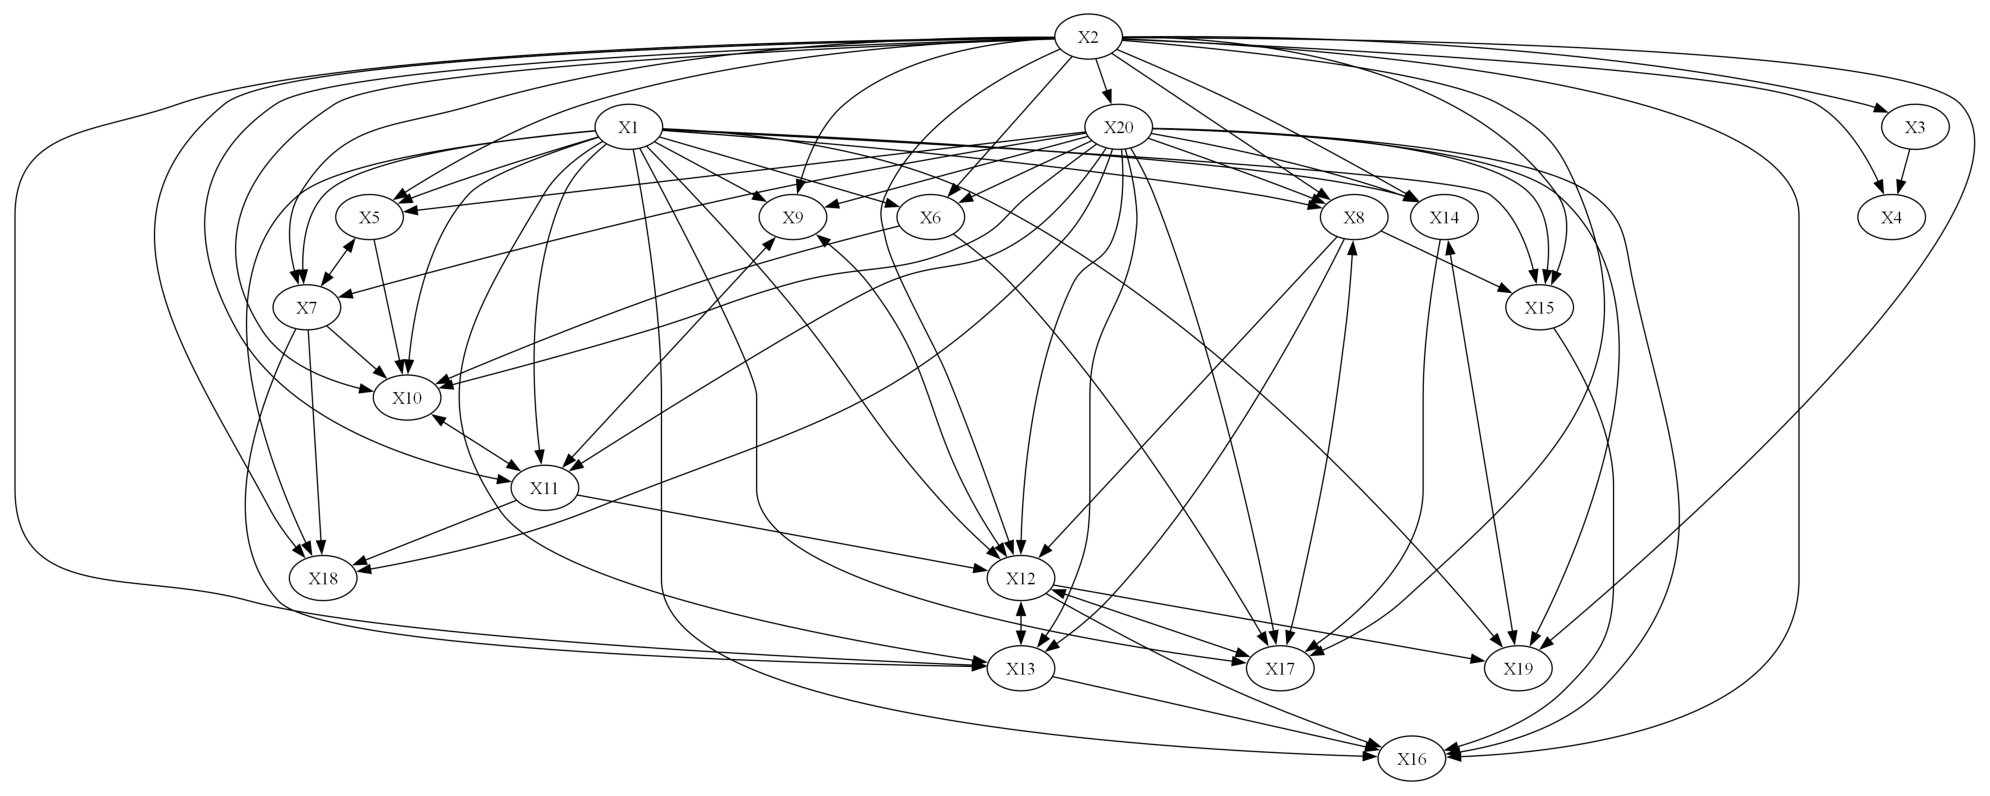

In [3]:
cluster_dag.true_mag.draw_pydot_graph()

{'C1': ['X1'], 'C2': ['X2'], 'C3': ['X3', 'X4'], 'C4': ['X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19'], 'C5': ['X20']}


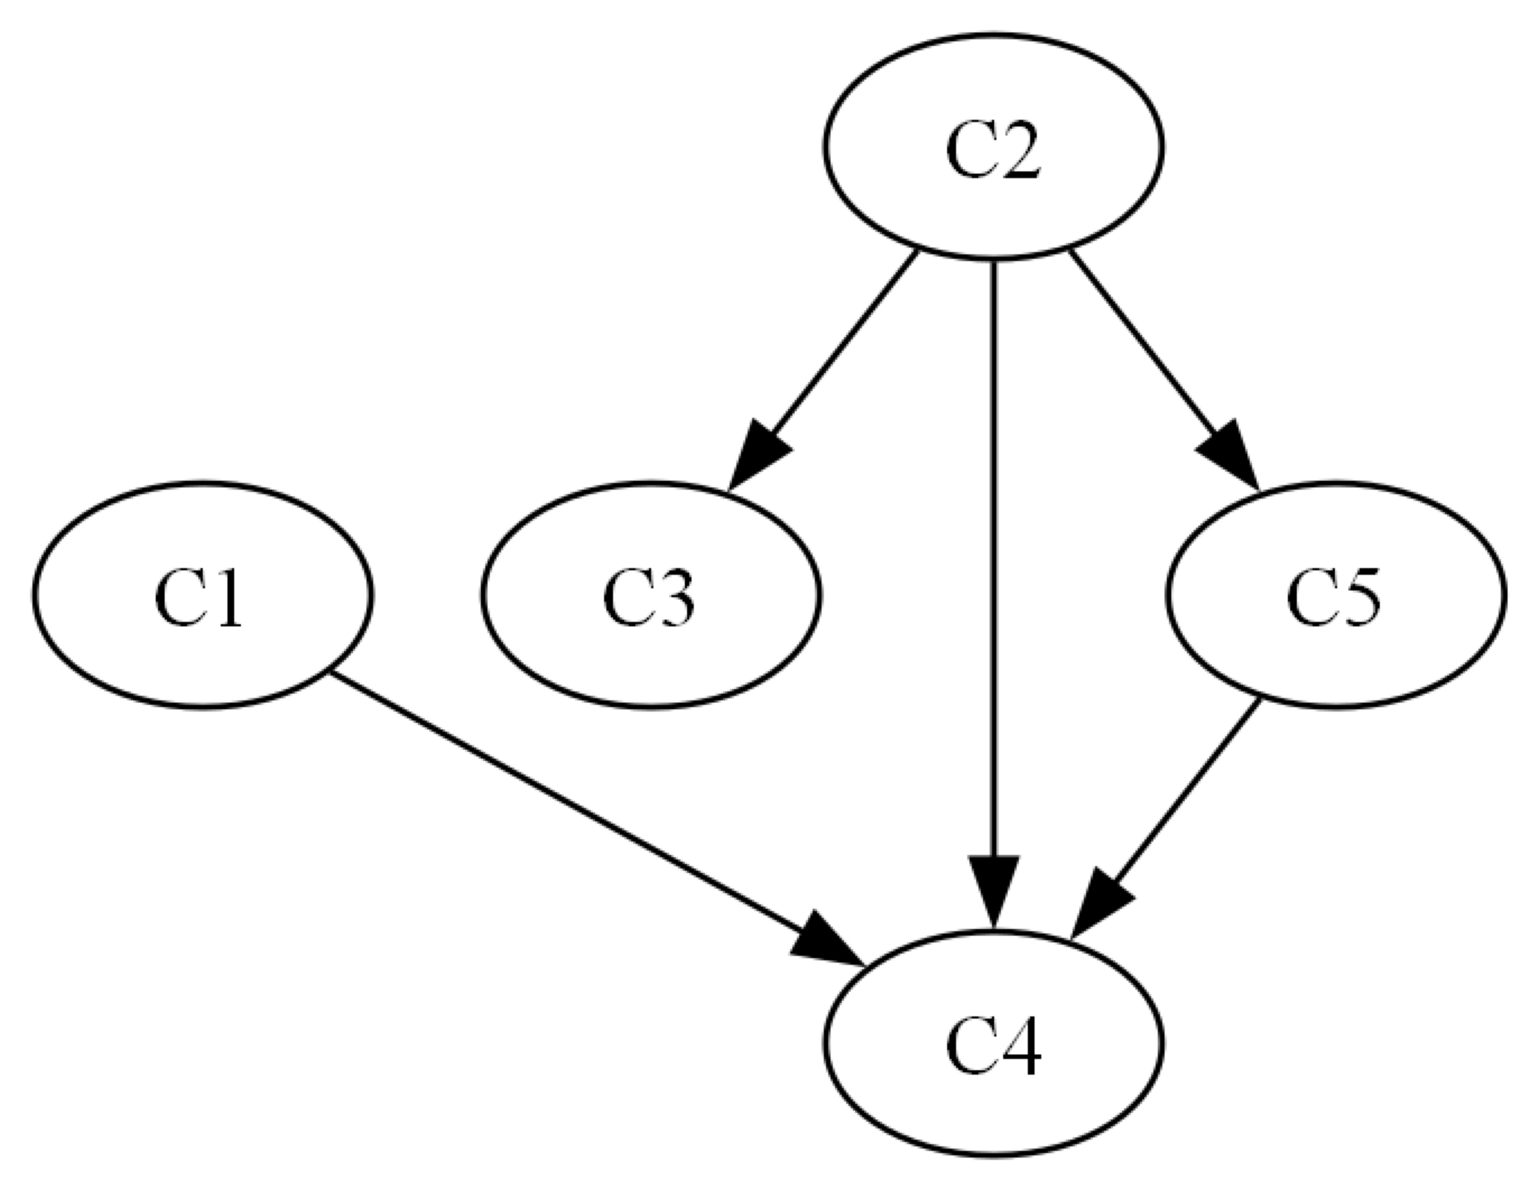

In [4]:
print(cluster_dag.cluster_mapping)
cluster_dag.cluster_graph.draw_pydot_graph()

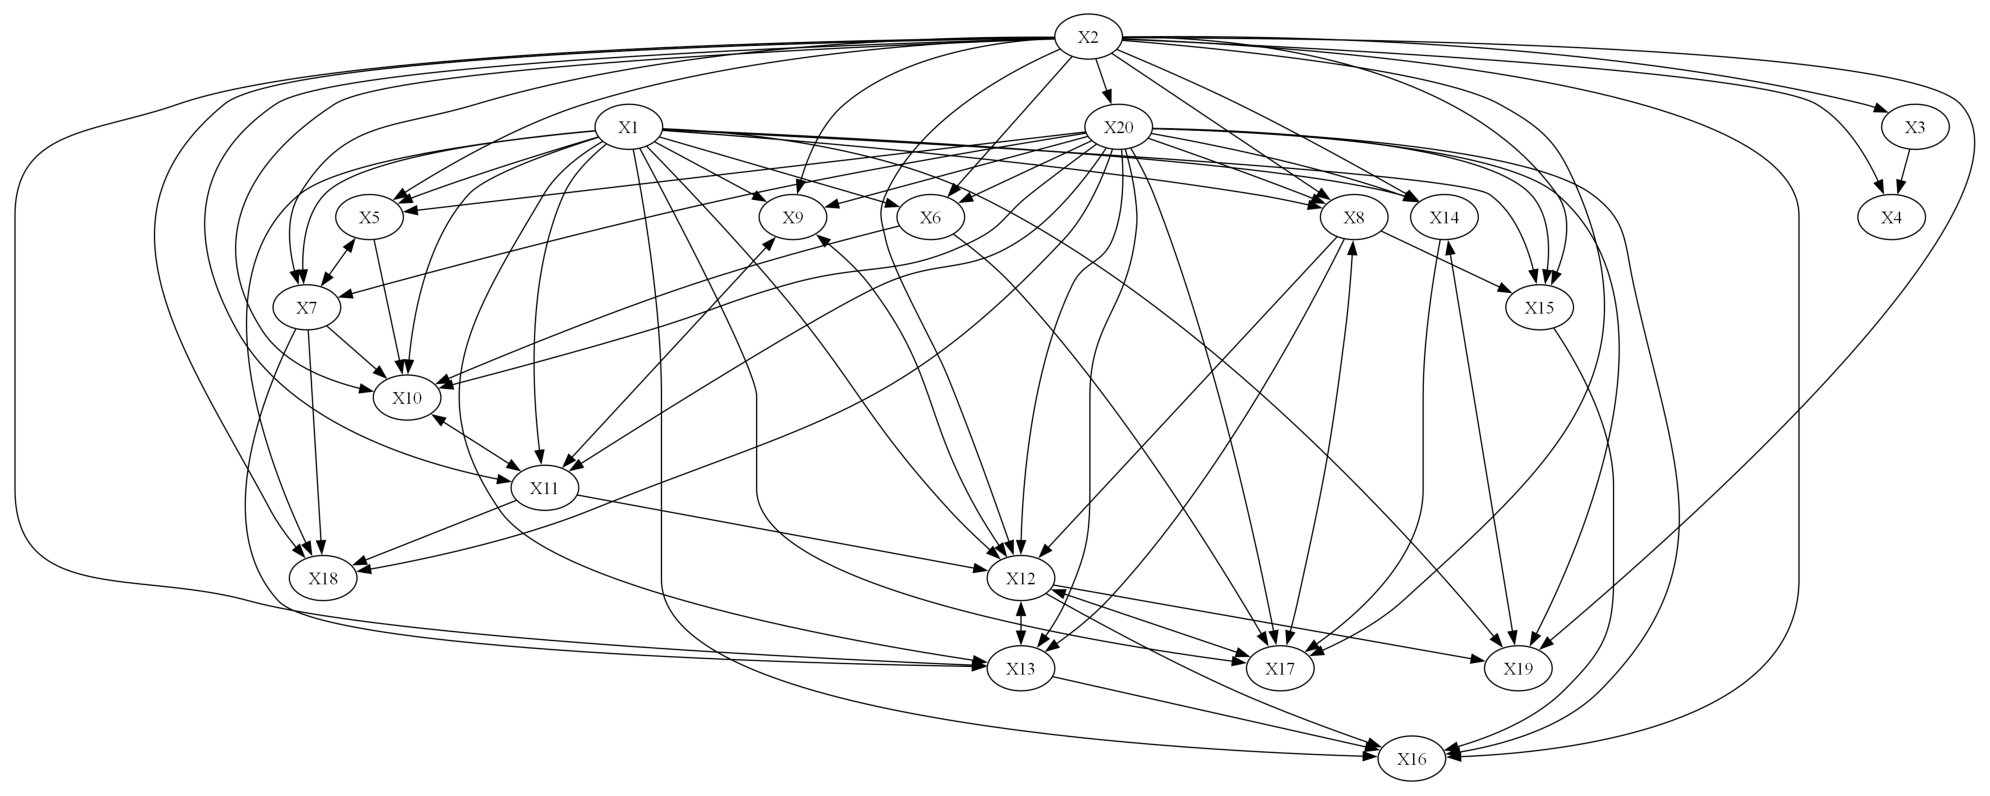

In [5]:
cluster_dag.true_mag.draw_pydot_graph()

ClusterFCI on C-DAG

In [6]:
cluster_fci = ClusterFCI(cluster_dag, dataset = cluster_dag.data, alpha = 0.05)
cluster_cg, cluster_edges = cluster_fci.run()

C4 phase, Depth=7, working on node 18: 100%|██████████| 15/15 [00:00<00:00, 1273.37it/s, duration: 0.62sec]


X8 --> X16
X16 --> X13


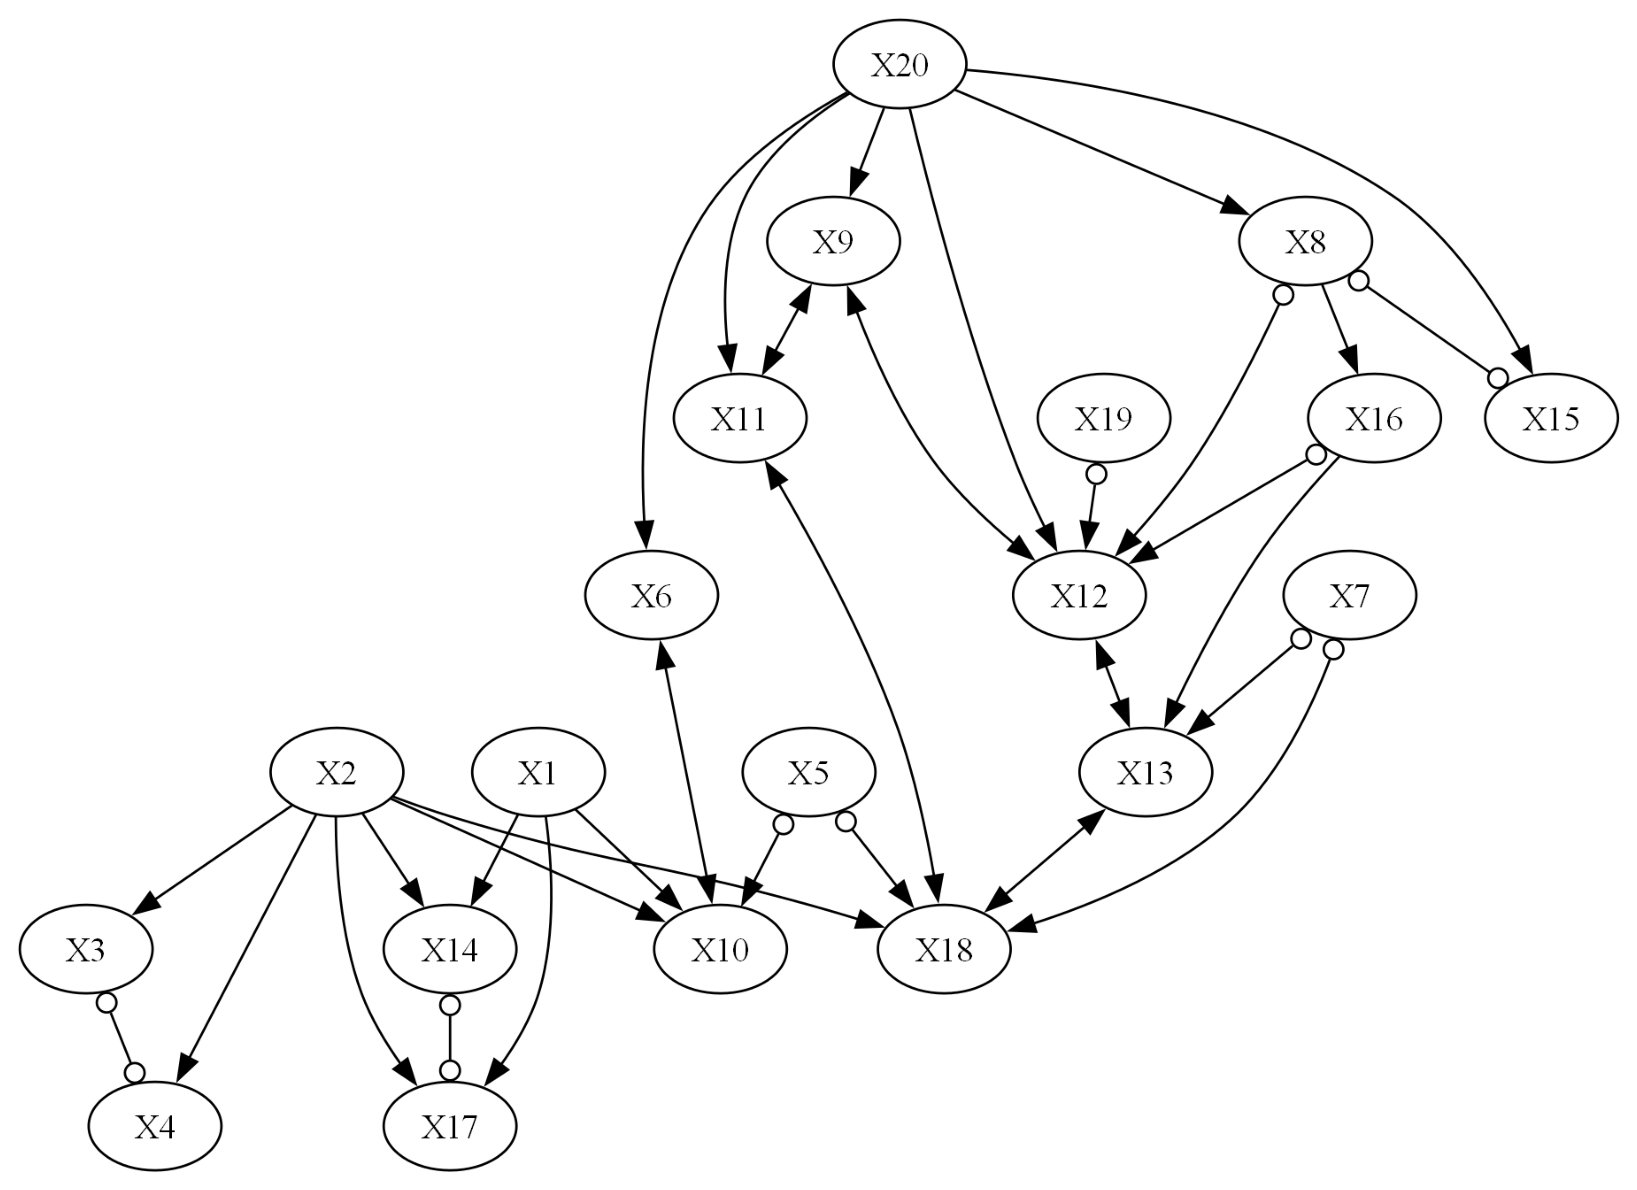

In [7]:
cluster_cg.draw_pydot_graph()

FCI

In [8]:
base_G, base_edges = fci(dataset = cluster_dag.data, alpha = 0.05, verbose = False)
base_cg = CausalGraph(len(base_G.get_node_names()))
base_cg.G = base_G

Depth=6, working on node 19: 100%|██████████| 20/20 [00:00<?, ?it/s]          


X1 --> X10
X1 --> X14
X2 --> X3
X2 --> X4
X2 --> X17
X6 --> X5
X5 --> X10
X10 --> X6
X9 --> X20
X16 --> X13
X17 --> X14
X20 --> X15


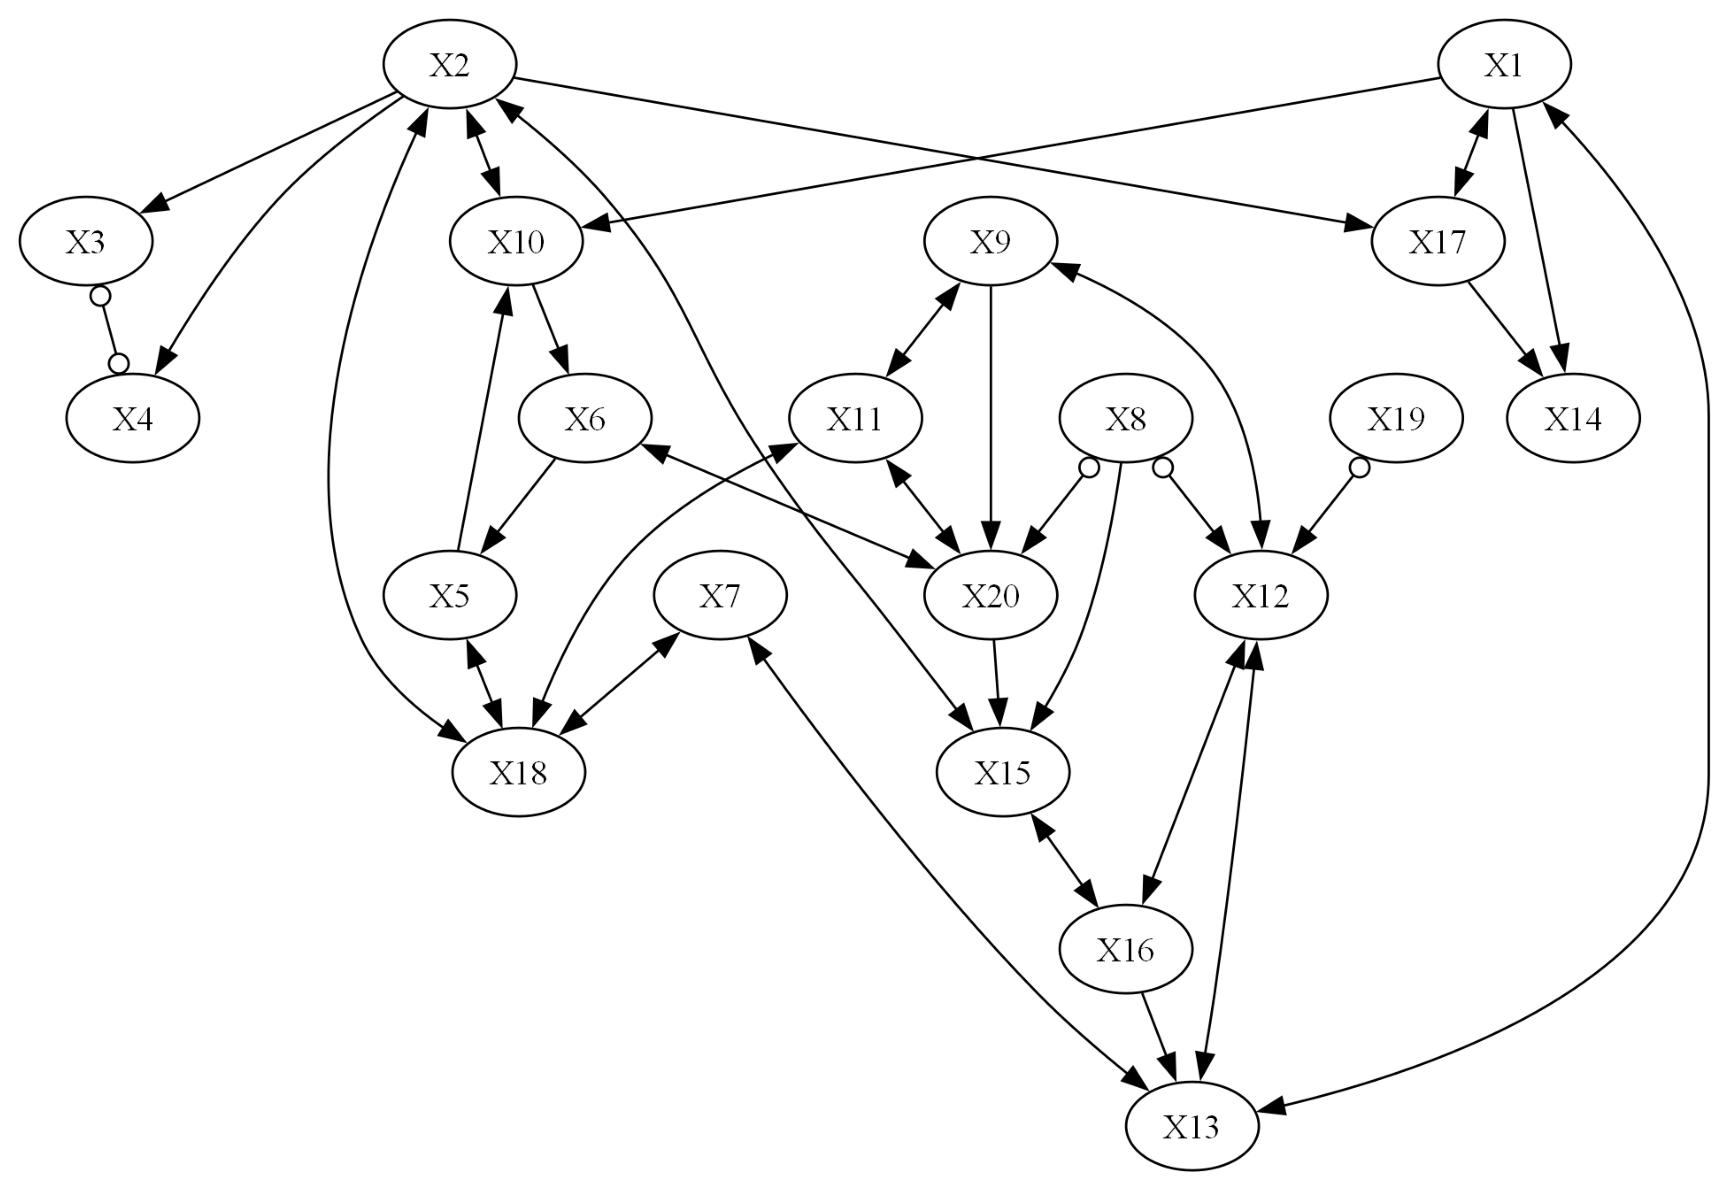

In [9]:
base_cg.draw_pydot_graph()

C-FCI vs FCITiers
Create tiers and connect clusters accordingly

In [10]:
import copy
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint

cluster_dag.tiers = copy.deepcopy(cluster_dag.cluster_graph)
n_clusters = len(cluster_dag.cluster_mapping.keys())
tiers_list = cluster_dag.get_cluster_topological_ordering()
for i in range(n_clusters):
    cluster_i = ClusterDAG.get_node_by_name(tiers_list[i], cluster_dag.tiers)
    for j in range(i, n_clusters):
        cluster_j = ClusterDAG.get_node_by_name(tiers_list[j], cluster_dag.tiers)
        edge = cluster_dag.tiers.G.get_edge(cluster_i, cluster_j)
        if edge is None:
            # add edge cluster_i -> cluster_j
            edge = Edge(cluster_i, cluster_j, Endpoint.TAIL, Endpoint.ARROW)
            cluster_dag.tiers.G.add_edge(edge)

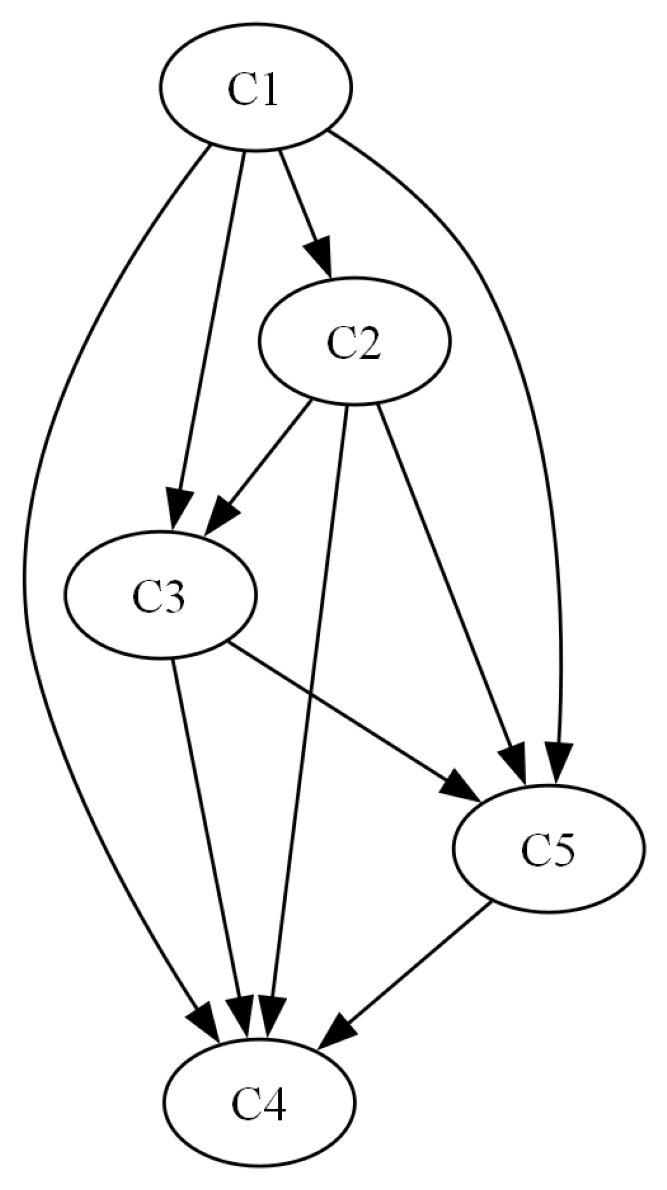

In [11]:
cluster_dag.tiers.draw_pydot_graph()

FCITiers on Tiers

In [12]:
fci_tiers_cg, fci_tiers_edges = fci_tiers(tiers = cluster_dag.get_cluster_topological_ordering(), \
                                          cluster_mapping = cluster_dag.cluster_mapping, \
                                          cdag = cluster_dag, \
                                            dataset = cluster_dag.data, alpha = 0.05, \
                                                verbose = False)

Depth=6, working on node 19: 100%|██████████| 20/20 [00:00<00:00, 5373.87it/s]


X6 --> X5
X5 --> X10
X18 --> X5
X10 --> X6
X8 --> X12
X16 --> X11
X16 --> X13


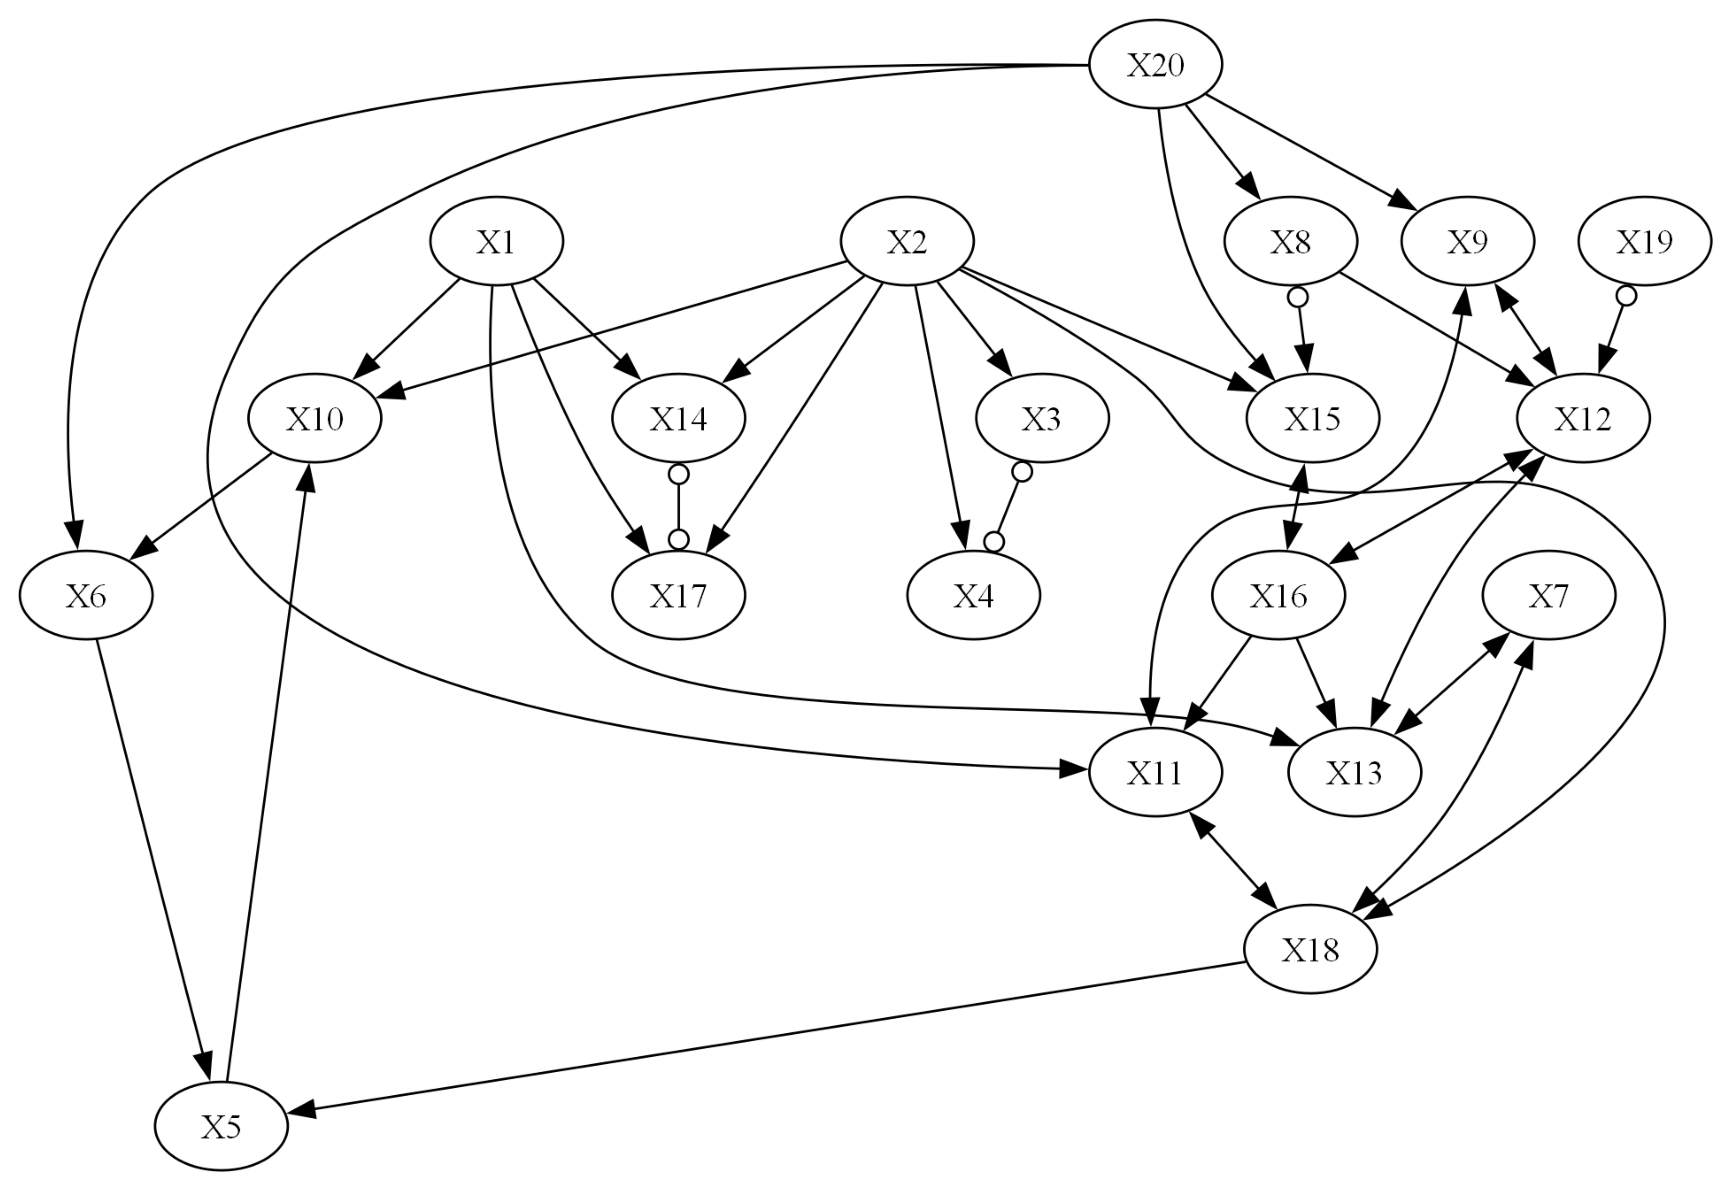

In [13]:
fci_tiers_cg.draw_pydot_graph()

C-FCI on Tiers

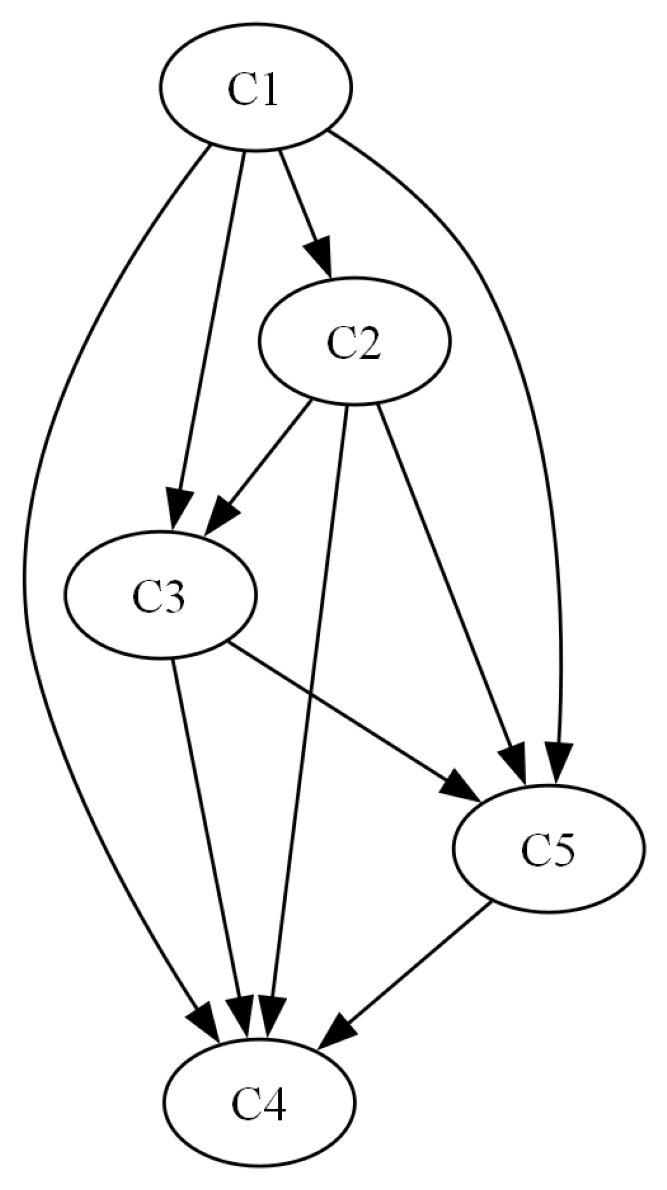

In [14]:
tiers_dag = copy.deepcopy(cluster_dag)
n_tiers = len(tiers_dag.cluster_mapping.keys())
tiers_list = tiers_dag.get_cluster_topological_ordering()
for i in range(n_tiers):
    cluster_i = ClusterDAG.get_node_by_name(tiers_list[i], tiers_dag.cluster_graph)
    for j in range(i, n_tiers):
        cluster_j = ClusterDAG.get_node_by_name(tiers_list[j], tiers_dag.cluster_graph)
        edge = tiers_dag.cluster_graph.G.get_edge(cluster_i, cluster_j)
        if edge is None:
            # add edge cluster_i -> cluster_j
            edge = Edge(cluster_i, cluster_j, Endpoint.TAIL, Endpoint.ARROW)
            tiers_dag.cluster_graph.G.add_edge(edge)
tiers_dag.cluster_graph.draw_pydot_graph()

In [15]:
cluster_fci_on_tiers = ClusterFCI(tiers_dag, dataset = tiers_dag.data, alpha = 0.05)
cluster_cg_on_tiers, cluster_edges_on_tiers = cluster_fci_on_tiers.run()

C4 phase, Depth=7, working on node 18: 100%|██████████| 15/15 [00:00<?, ?it/s, duration: 0.56sec]


X8 --> X16
X16 --> X13


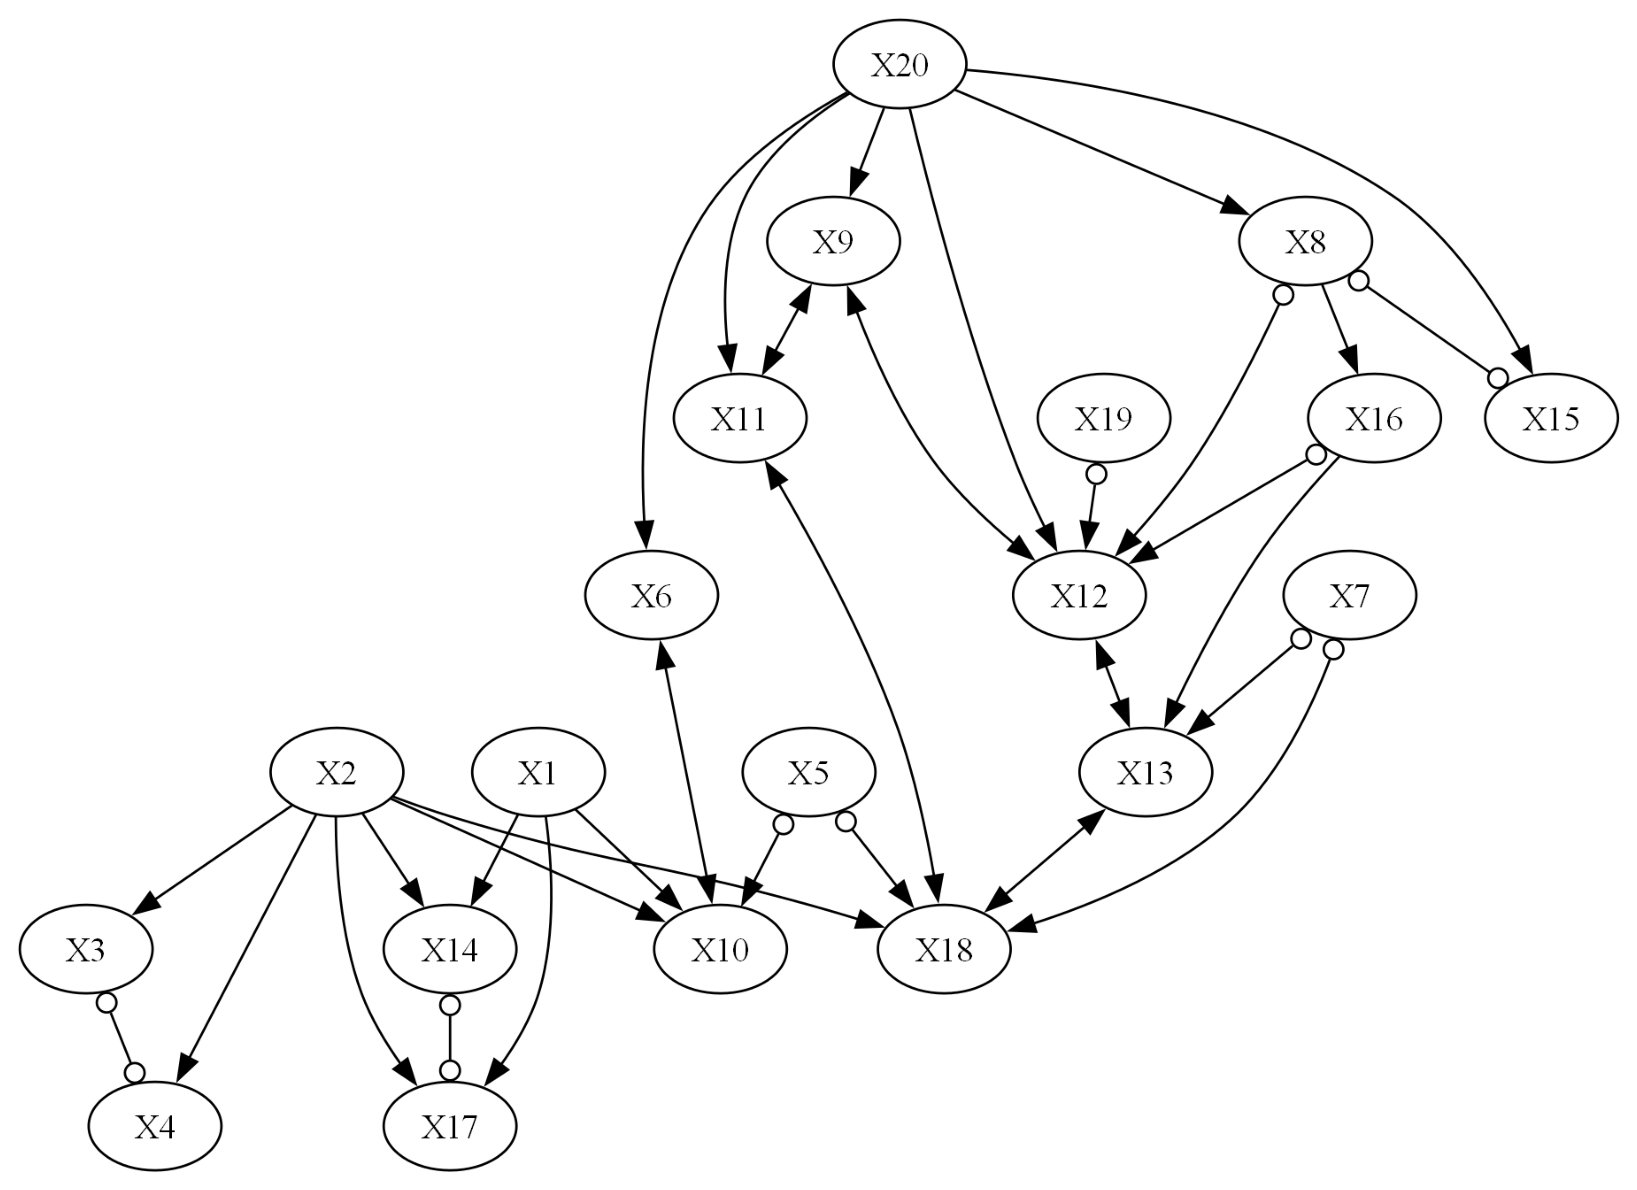

In [16]:
cluster_cg_on_tiers.draw_pydot_graph()

Evaluate

In [17]:
eval_c_fci = Evaluator(truth = cluster_dag.true_mag.G, est = cluster_cg.G)
eval_fci = Evaluator(truth = cluster_dag.true_mag.G, est = base_G)
eval_fci_tiers = Evaluator(truth = cluster_dag.true_mag.G, est = fci_tiers_cg.G)
eval_c_fci_on_tiers = Evaluator(truth = cluster_dag.true_mag.G, est = cluster_cg_on_tiers.G)

In [18]:
c_fci_adjacency_confusion, c_fci_arrow_confusion, c_fci_shd, c_fci_sid = eval_c_fci.get_causallearn_metrics(sid=False)
fci_adjacency_confusion, fci_arrow_confusion, fci_shd, fci_sid = eval_fci.get_causallearn_metrics(sid=False)
fci_tiers_adjacency_confusion, fci_tiers_arrow_confusion, fci_tiers_shd, fci_tiers_sid = eval_fci_tiers.get_causallearn_metrics(sid=False)
c_fci_on_tiers_adjacency_confusion, c_fci_on_tiers_arrow_confusion, c_fci_on_tiers_shd, c_fci_on_tiers_sid = eval_c_fci_on_tiers.get_causallearn_metrics(sid=False)


In [19]:
# Adjacency confusion matrix
# print("---------------Adjacency Confusion-----------------")
print(f"Base FCI: precision = {fci_adjacency_confusion['precision']:.2f}, recall = {fci_adjacency_confusion['recall']:.2f}, f1 = {fci_adjacency_confusion['f1_score']:.2f}, shd = {fci_shd}")
print(f"Cluster FCI: precision = {c_fci_adjacency_confusion['precision']:.2f}, recall = {c_fci_adjacency_confusion['recall']:.2f}, f1 = {c_fci_adjacency_confusion['f1_score']:.2f}, shd = {c_fci_shd}")
print(f"FCI Tiers: precision = {fci_tiers_adjacency_confusion['precision']:.2f}, recall = {fci_tiers_adjacency_confusion['recall']:.2f}, f1 = {fci_tiers_adjacency_confusion['f1_score']:.2f}, shd = {fci_tiers_shd}")
print(f"Cluster FCI on Tiers: precision = {c_fci_on_tiers_adjacency_confusion['precision']:.2f}, recall = {c_fci_on_tiers_adjacency_confusion['recall']:.2f}, f1 = {c_fci_on_tiers_adjacency_confusion['f1_score']:.2f}, shd = {c_fci_on_tiers_shd}")

Base FCI: precision = 0.94, recall = 0.42, f1 = 0.58, shd = 68
Cluster FCI: precision = 0.91, recall = 0.41, f1 = 0.57, shd = 57
FCI Tiers: precision = 0.91, recall = 0.44, f1 = 0.59, shd = 58
Cluster FCI on Tiers: precision = 0.91, recall = 0.41, f1 = 0.57, shd = 57


### Gridsearch simulation

Cluster-FCI on C-ADMGs (not satisfying tbk necessarily)

In [20]:
# # 30 experiments take around 45 seconds
# config_path = 'clustercausal\experiments\configs\cluster_fci_simulation.yaml'
# config_path = config_path.replace('\\', '/')
# experiment = ExperimentRunner(config_path)
# experiment.run_gridsearch_experiment()

In [21]:
# data = load_experiment_folder('clustercausal\experiments\_results')
# data.to_pickle('clustercausal\experiments\_results_dataframes_for_simulations\data_clusterFCI_simulation_incl_FCITiers.pkl')


data = pd.read_pickle('clustercausal\experiments\_results_dataframes_for_simulations\simulation_3_clusterFCI_simulation_incl_FCITiers.pkl')

In [22]:
prec_recall_metrics_with_fcitiers = ['base_adj_precision', 'cluster_adj_precision', 'fcitiers_adj_precision',\
              'base_adj_recall', 'cluster_adj_recall', 'fcitiers_adj_recall', \
                'base_adj_f1_score', 'cluster_adj_f1_score', 'fcitiers_adj_f1_score']
extended_metrics = prec_recall_metrics_with_fcitiers + ['base_base_shd', 'cluster_cluster_shd', 'fcitiers_fcitiers_shd', 'Base indep tests', 'Cluster indep tests', 'FCITiers indep tests']
data[extended_metrics].mean()

base_adj_precision           0.359648
cluster_adj_precision        0.352124
fcitiers_adj_precision       0.324672
base_adj_recall              0.215337
cluster_adj_recall           0.248021
fcitiers_adj_recall          0.227492
base_adj_f1_score            0.262486
cluster_adj_f1_score         0.286389
fcitiers_adj_f1_score        0.263164
base_base_shd               29.344444
cluster_cluster_shd         30.377778
fcitiers_fcitiers_shd       29.850000
Base indep tests          1008.211111
Cluster indep tests        558.516667
FCITiers indep tests      1138.616667
dtype: float64

In [23]:
arrow_metrics = ['base_arrow_precision', 'cluster_arrow_precision', 'fcitiers_arrow_precision',\
                'base_arrow_recall', 'cluster_arrow_recall', 'fcitiers_arrow_recall',\
                'base_arrow_f1_score', 'cluster_arrow_f1_score', 'fcitiers_arrow_f1_score']
data[arrow_metrics].mean()

base_arrow_precision        0.244590
cluster_arrow_precision     0.298522
fcitiers_arrow_precision    0.297641
base_arrow_recall           0.118579
cluster_arrow_recall        0.201315
fcitiers_arrow_recall       0.166846
base_arrow_f1_score         0.152887
cluster_arrow_f1_score      0.235506
fcitiers_arrow_f1_score     0.208670
dtype: float64

In [24]:
# unique values of the columns
configurations = ['n_nodes', 'alpha', 'n_clusters', 'n_edges', 'dag_method', 'distribution_type']
for config in configurations:
    print(f'{config}: {data[config].unique()}')

n_nodes: [18.]
alpha: [0.05]
n_clusters: [2. 3. 4. 5. 6. 7.]
n_edges: [18. 24. 30.]
dag_method: ['erdos_renyi']
distribution_type: ['gauss']


Cluster-FCI vs FCITiers on C-DAG/ TBK

In [25]:
# # 30 experiments take around 45 seconds
# config_path = 'clustercausal\experiments\configs\cluster_vsfcitiers_on_tiers.yaml'
# config_path = config_path.replace('\\', '/')
# experiment = ExperimentRunner(config_path)
# experiment.run_gridsearch_experiment()

In [26]:
# data = load_experiment_folder('clustercausal\experiments\_results')
# data.to_pickle('clustercausal\experiments\_results_dataframes_for_simulations\data_clusterFCI_simulation_incl_FCITiers_on_tiers.pkl')

data = pd.read_pickle('clustercausal\experiments\_results_dataframes_for_simulations\simulation_4_clusterFCI_simulation_incl_FCITiers_on_tiers.pkl')

In [27]:
prec_recall_metrics_with_fcitiers = ['base_adj_precision', 'cluster_adj_precision', 'fcitiers_adj_precision',\
              'base_adj_recall', 'cluster_adj_recall', 'fcitiers_adj_recall', \
                'base_adj_f1_score', 'cluster_adj_f1_score', 'fcitiers_adj_f1_score']
extended_metrics = prec_recall_metrics_with_fcitiers + ['base_base_shd', 'cluster_cluster_shd', 'fcitiers_fcitiers_shd', 'Base indep tests', 'Cluster indep tests', 'FCITiers indep tests']
data[extended_metrics].mean()

base_adj_precision           0.949116
cluster_adj_precision        0.932808
fcitiers_adj_precision       0.934972
base_adj_recall              0.627807
cluster_adj_recall           0.638117
fcitiers_adj_recall          0.638014
base_adj_f1_score            0.747505
cluster_adj_f1_score         0.750285
fcitiers_adj_f1_score        0.750590
base_base_shd               20.155556
cluster_cluster_shd         16.088889
fcitiers_fcitiers_shd       16.600000
Base indep tests          1474.900000
Cluster indep tests        822.733333
FCITiers indep tests      1567.711111
dtype: float64

In [28]:
arrow_metrics = ['base_arrow_precision', 'cluster_arrow_precision', 'fcitiers_arrow_precision',\
                'base_arrow_recall', 'cluster_arrow_recall', 'fcitiers_arrow_recall',\
                'base_arrow_f1_score', 'cluster_arrow_f1_score', 'fcitiers_arrow_f1_score']
data[arrow_metrics].mean()

base_arrow_precision        0.669776
cluster_arrow_precision     0.810844
fcitiers_arrow_precision    0.811820
base_arrow_recall           0.409554
cluster_arrow_recall        0.430080
fcitiers_arrow_recall       0.443791
base_arrow_f1_score         0.494626
cluster_arrow_f1_score      0.550869
fcitiers_arrow_f1_score     0.563990
dtype: float64

In [29]:
# unique values of the columns
configurations = ['n_nodes', 'alpha', 'n_clusters', 'n_edges', 'dag_method', 'distribution_type']
for config in configurations:
    print(f'{config}: {data[config].unique()}')

n_nodes: [15.]
alpha: [0.05]
n_clusters: [3. 4. 5.]
n_edges: [15. 20. 25.]
dag_method: ['erdos_renyi']
distribution_type: ['gauss']


In [31]:
print(np.sum(data['base_adj_f1_score'] == data['fcitiers_adj_f1_score']))
print(np.sum(data['base_arrow_f1_score'] == data['fcitiers_arrow_f1_score']))
print(np.sum(data['base_base_shd'] == data['fcitiers_fcitiers_shd']))

51
5
16


In [32]:
# unique values of the columns
configurations = ['n_nodes', 'alpha', 'n_clusters', 'n_edges', 'dag_method', 'distribution_type']
for config in configurations:
    print(f'{config}: {data[config].unique()}')

n_nodes: [15.]
alpha: [0.05]
n_clusters: [3. 4. 5.]
n_edges: [15. 20. 25.]
dag_method: ['erdos_renyi']
distribution_type: ['gauss']


In [34]:
prec_recall_metrics_with_fcitiers = ['base_adj_precision', 'cluster_adj_precision', 'fcitiers_adj_precision',\
              'base_adj_recall', 'cluster_adj_recall', 'fcitiers_adj_recall', \
                'base_adj_f1_score', 'cluster_adj_f1_score', 'fcitiers_adj_f1_score']
data[prec_recall_metrics_with_fcitiers].mean()

base_adj_precision        0.949116
cluster_adj_precision     0.932808
fcitiers_adj_precision    0.934972
base_adj_recall           0.627807
cluster_adj_recall        0.638117
fcitiers_adj_recall       0.638014
base_adj_f1_score         0.747505
cluster_adj_f1_score      0.750285
fcitiers_adj_f1_score     0.750590
dtype: float64

In [35]:
extended_metrics = prec_recall_metrics_with_fcitiers + ['base_base_shd', 'cluster_cluster_shd', 'fcitiers_fcitiers_shd', 'Base indep tests', 'Cluster indep tests', 'FCITiers indep tests']
data[extended_metrics].mean()

base_adj_precision           0.949116
cluster_adj_precision        0.932808
fcitiers_adj_precision       0.934972
base_adj_recall              0.627807
cluster_adj_recall           0.638117
fcitiers_adj_recall          0.638014
base_adj_f1_score            0.747505
cluster_adj_f1_score         0.750285
fcitiers_adj_f1_score        0.750590
base_base_shd               20.155556
cluster_cluster_shd         16.088889
fcitiers_fcitiers_shd       16.600000
Base indep tests          1474.900000
Cluster indep tests        822.733333
FCITiers indep tests      1567.711111
dtype: float64

In [36]:
eval_df = pd.DataFrame(columns = ['Metric', 'Base', 'ClusterFCI', 'FCITiers'])


In [37]:
arrow_metrics = ['base_arrow_precision', 'cluster_arrow_precision', 'fcitiers_arrow_precision',\
                'base_arrow_recall', 'cluster_arrow_recall', 'fcitiers_arrow_recall',\
                'base_arrow_f1_score', 'cluster_arrow_f1_score', 'fcitiers_arrow_f1_score']

In [38]:
data[arrow_metrics].describe()

base_arrow_precision  cluster_arrow_precision  \
count             90.000000                90.000000   
mean               0.669776                 0.810844   
std                0.124846                 0.143186   
min                0.214286                 0.421053   
25%                0.589325                 0.722222   
50%                0.683014                 0.828431   
75%                0.750000                 0.923077   
max                1.000000                 1.000000   

       fcitiers_arrow_precision  base_arrow_recall  cluster_arrow_recall  \
count                 90.000000          90.000000             90.000000   
mean                   0.811820           0.409554              0.430080   
std                    0.136563           0.159404              0.152544   
min                    0.428571           0.093750              0.131148   
25%                    0.724359           0.291667              0.308355   
50%                    0.826087           0.409278              0.411458   
75%                    0.903571           0.524185              0.553763   
max                    1.000000           0.807692              0.769231   

       fcitiers_arrow_recall  base_arrow_f1_score  cluster_arrow_f1_score  \
count              90.000000            90.000000               90.000000   
mean                0.443791             0.494626                0.550869   
std                 0.148649             0.142711                0.150504   
min                 0.142857             0.130435                0.200000   
25%                 0.341048             0.407828                0.444444   
50%                 0.435728             0.508621                0.563019   
75%                 0.555556             0.617081                0.679643   
max                 0.730769             0.807692                0.816327   

       fcitiers_arrow_f1_score  
count                90.000000  
mean                  0.563990  
std                   0.146629  
min                   0.250000  
25%                   0.461284  
50%                   0.568733  
75%                   0.680638  
max                   0.844444

### Testing/ other

In [ ]:
seed = None
num_edges = []
for i in range(50):
    simulation = Simulator(n_nodes = 20, n_edges = 20, cluster_method = 'cdag', n_clusters = 4, n_c_edges = 5, seed = seed)
    cluster_dag = simulation.run_with_tbk()
    no_edges_true_dag = len(cluster_dag.true_dag.G.get_graph_edges())
    num_edges.append(no_edges_true_dag)


2025-04-29 16:20:58,663 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:20:58,916 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:20:59,000 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:20:59,052 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:20:59,118 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:20:59,186 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:20:59,470 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:20:59,679 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:20:59,793 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:20:59,836 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:20:59,884 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:00,068 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:21:00,236 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:00,507 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:00,741 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:01,019 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:21:01,192 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:01,441 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:21:01,555 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:21:01,675 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:01,921 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:02,021 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:02,180 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:21:02,342 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:02,443 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:21:02,526 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:21:02,605 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:02,726 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:02,940 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:21:03,091 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:03,187 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:03,478 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:21:03,610 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:21:03,654 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:03,942 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:04,197 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:21:04,309 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:04,576 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:21:04,641 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:04,877 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:21:04,939 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:21:05,060 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:05,130 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:21:05,326 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:05,427 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:05,643 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:05,920 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2025-04-29 16:21:06,123 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:06,211 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


2025-04-29 16:21:06,427 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


(array([ 4.,  2., 13.,  4.,  4.,  9.,  4.,  6.,  0.,  4.]),
 array([22. , 23.4, 24.8, 26.2, 27.6, 29. , 30.4, 31.8, 33.2, 34.6, 36. ]),
 <BarContainer object of 10 artists>)

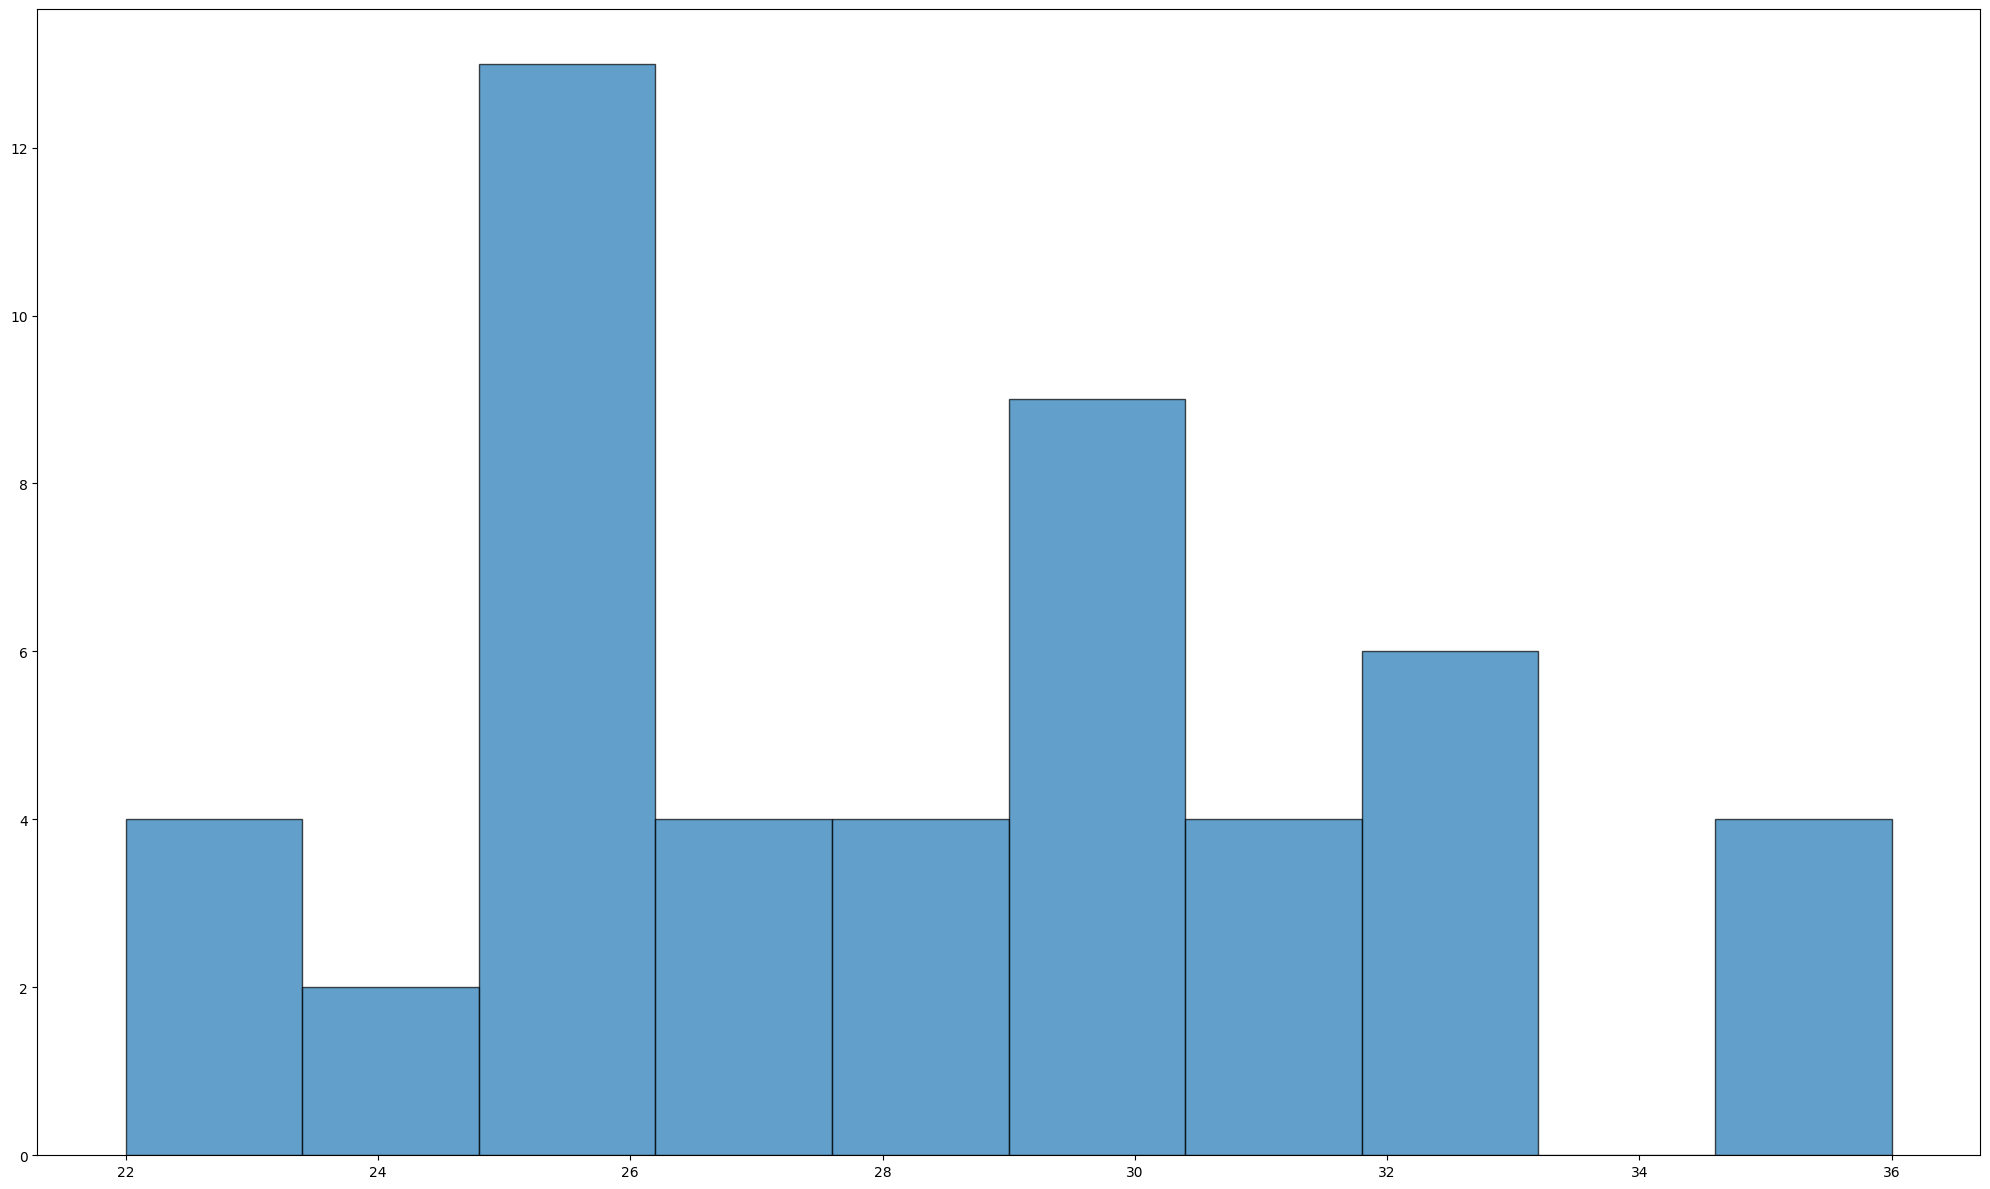

In [ ]:
plt.hist(num_edges, bins=10, edgecolor='black', alpha=0.7)

In [ ]:
# simulation = Simulator(n_nodes = 20, n_edges = 50, cluster_method = 'cdag', n_clusters = 4, seed = 232)
# seed = np.random.randint(0, 1000)
seed = 501
seed = None
# A note on n_c_edges: the number of edges is n_clusters*(n_clusters-1) * n_c_edges / n_clusters**2 in expectation, 
# as they are created probabilistically. So the number of cluster edges is only approximately controllable
simulation = Simulator(n_nodes = 20, n_edges = 20, cluster_method = 'cdag', n_clusters = 5, n_c_edges = 6, seed = seed)
# simulation = Simulator(n_nodes = 20, n_edges = 50, cluster_method = 'cdag', n_clusters = 4)
cluster_dag = simulation.run_with_tbk()

2025-04-29 16:21:06,945 - c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


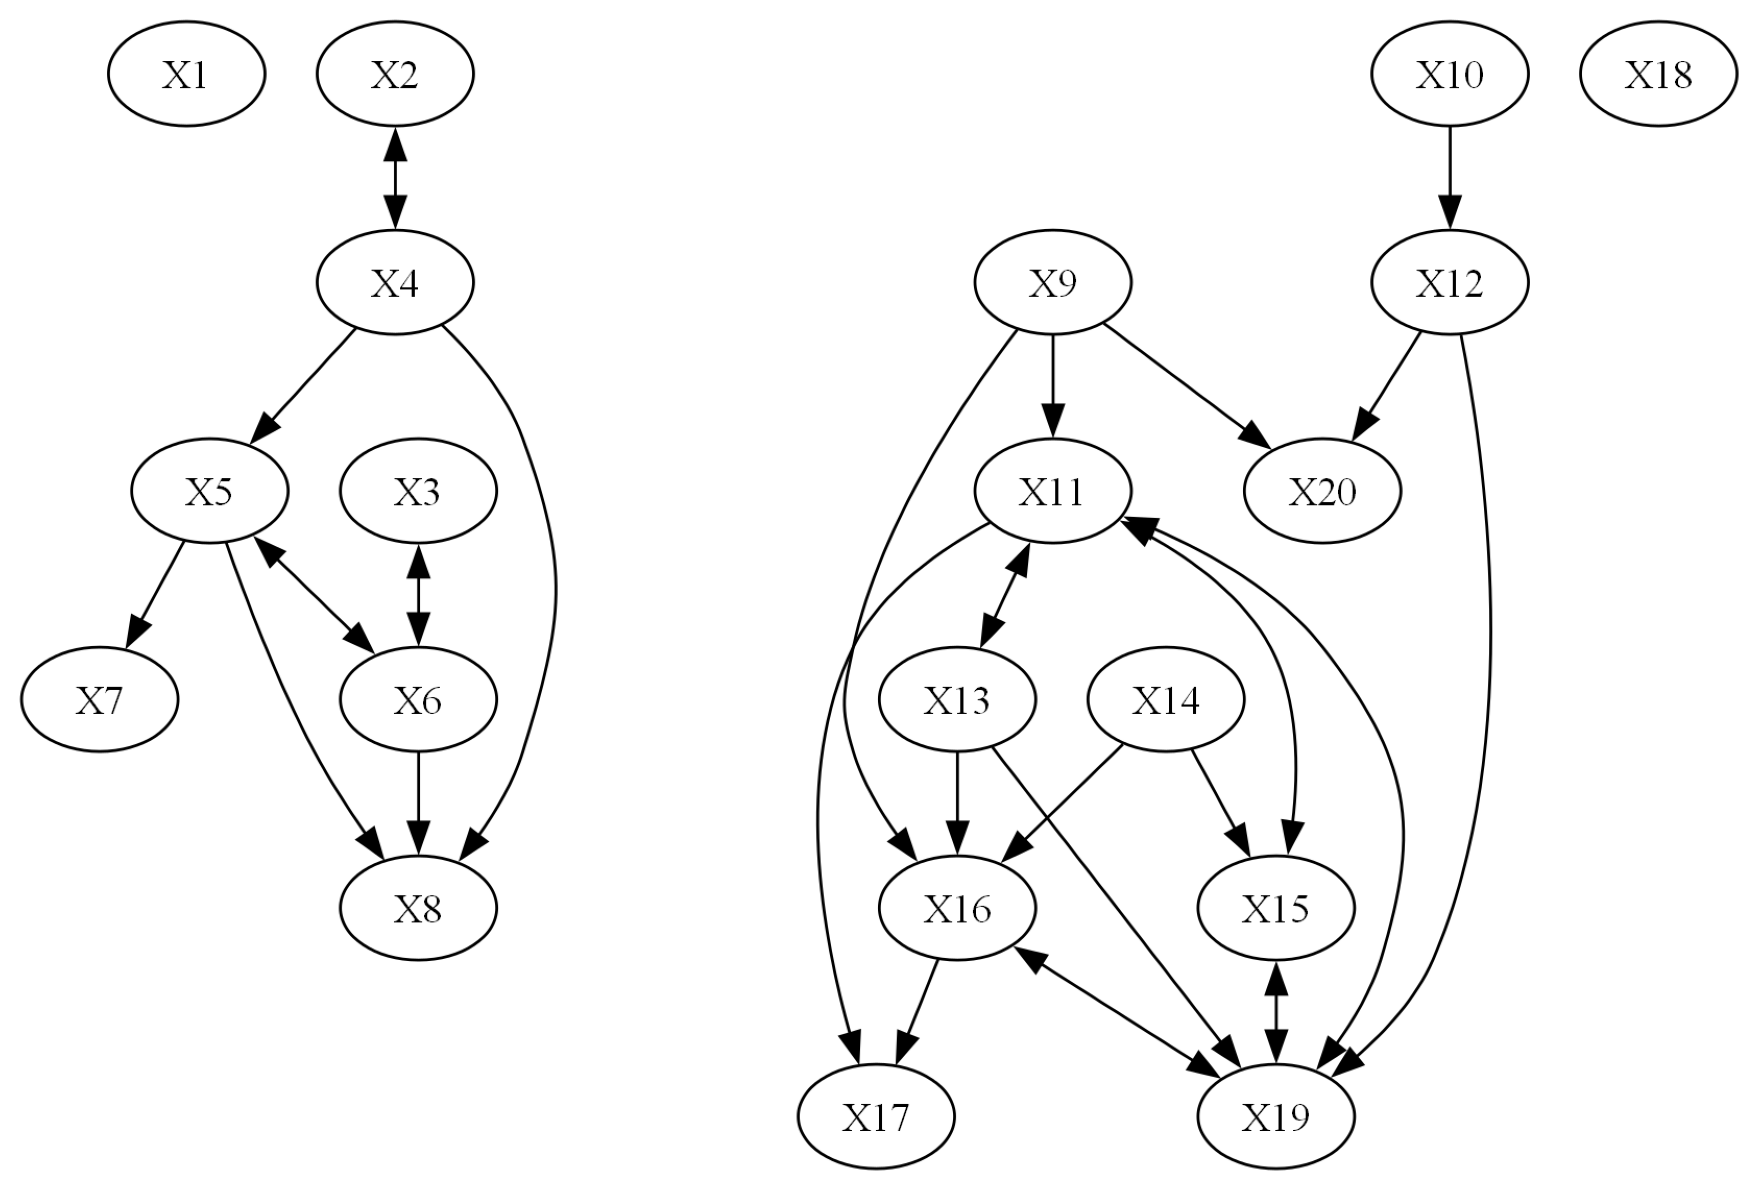

In [ ]:
cluster_dag.true_dag.draw_pydot_graph()

In [ ]:
no_edges_true_dag = len(cluster_dag.true_dag.G.get_graph_edges())
print(f"Number of edges in the true DAG: {no_edges_true_dag}")

Number of edges in the true DAG: 25


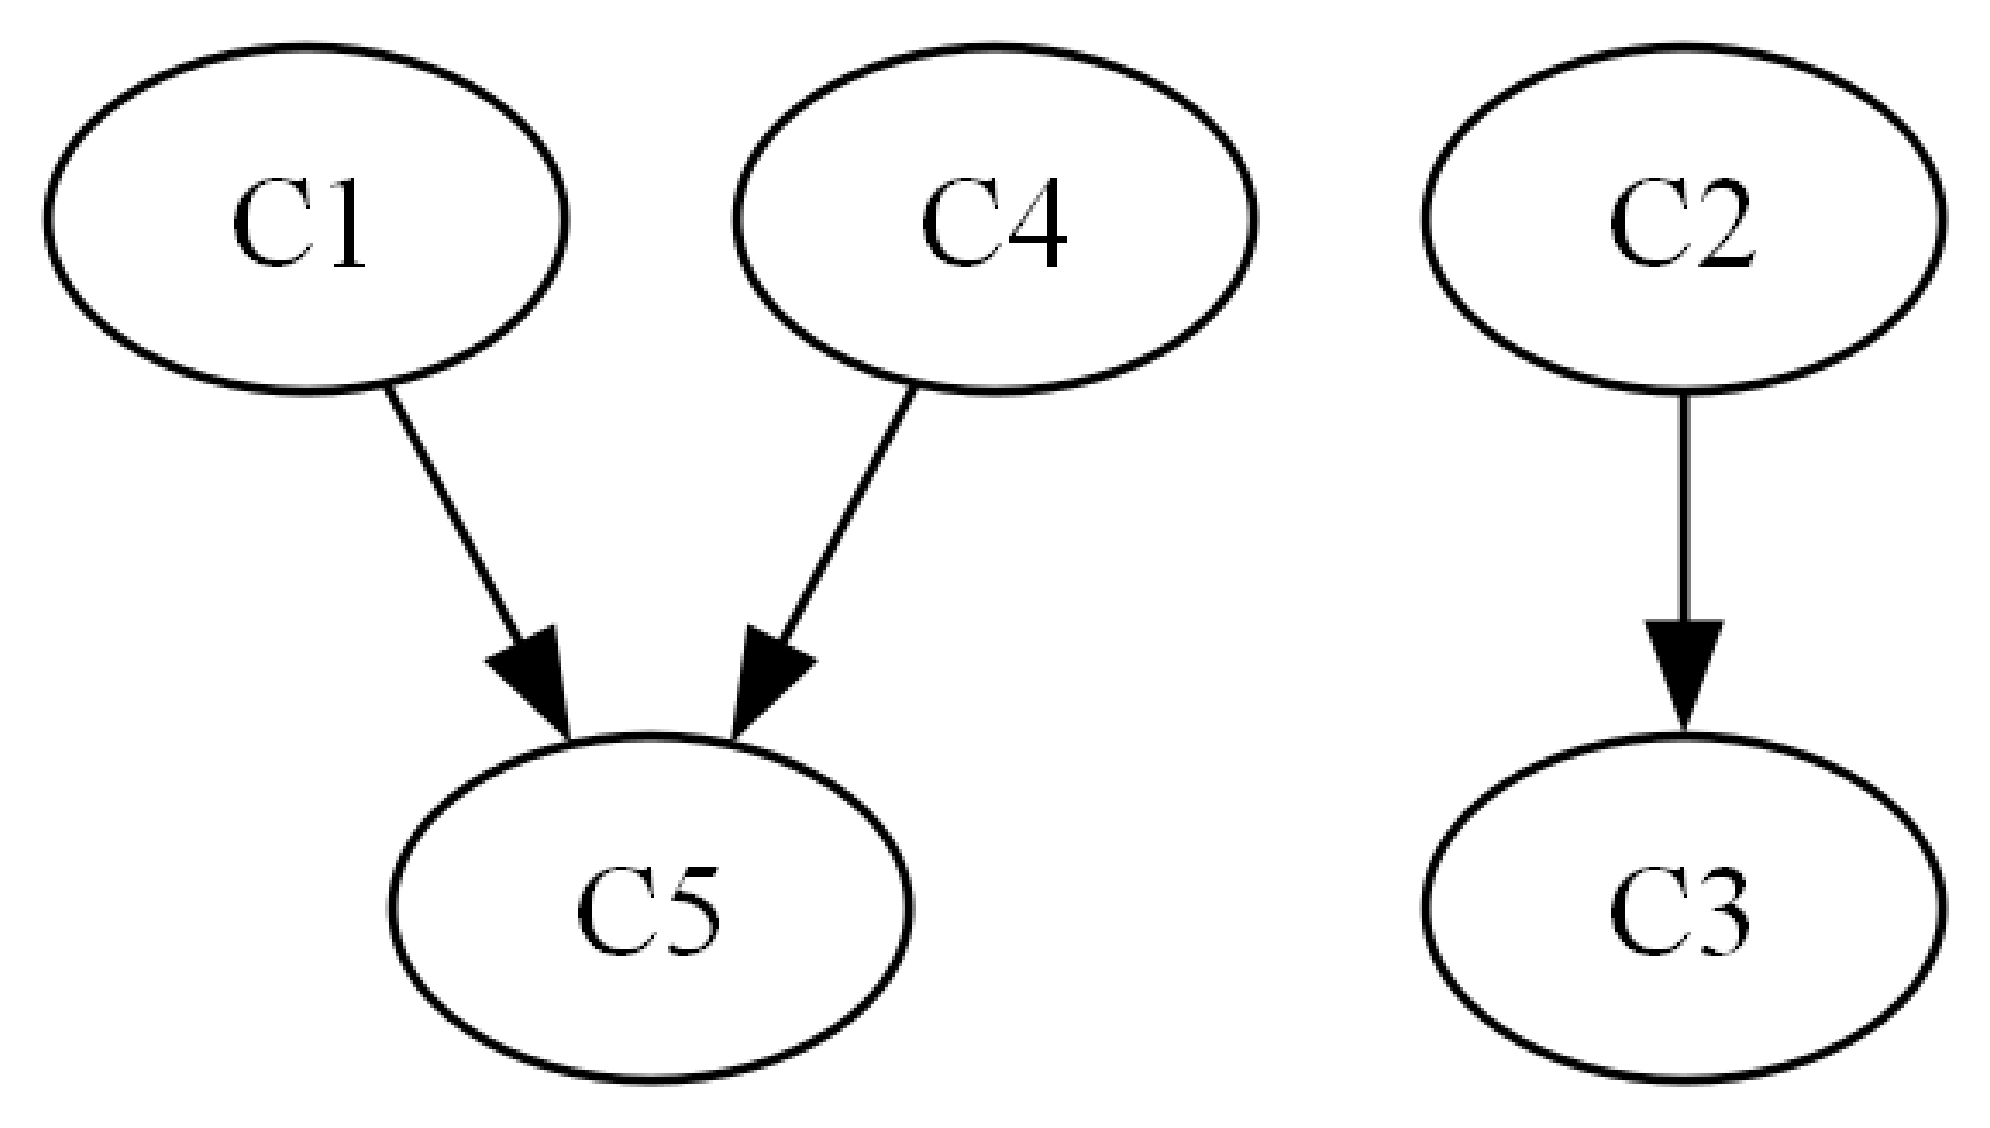

In [ ]:
cluster_dag.cluster_graph.draw_pydot_graph()

In [ ]:
cluster_dag.cluster_mapping

{'C1': ['X1'],
 'C2': ['X2', 'X3', 'X4', 'X5', 'X6', 'X7'],
 'C3': ['X8'],
 'C4': ['X9',
  'X10',
  'X11',
  'X12',
  'X13',
  'X14',
  'X15',
  'X16',
  'X17',
  'X18',
  'X19'],
 'C5': ['X20']}